## $\S$ 3.4.4. Least Angle Regression

Least Angle Regression (LAR) is a relative newcomer (Efron et al., 2004), and can be viewed as a kind of "democratic" version of forward stepwise regression ($\S$ 3.3.2). Forward stepwise regression builds a model sequentially, adding one variable at a time. At each step, it identifies the best variable to include in the *active set*, and then updates the least squares fit to include all the active variables.

LAR uses a similar strategy, but only enters "as much" of a predictor as it deserves.
1. Identify the variable most correlated with the response.
2. Rather than fit this variable completely, LAR moves the coefficient of this variable continuously toward its least-sqaures value (causing its correlation with the evolving residual to decrease in absolute value).
3. As soon as another variable "catches up" in terms of correlation with residual, the process is paused.
4. The second variable then joins the active set, and their coefficients are moved together in a way that keeps their correlations tied and decreasing.
5. This process is continued until all the variables are in the model, and ends at the full least-squares fit.

Below is the algorithm in detail.

### Algorithm 3.2. Least Angle Regression

1. Standardize the predictors to have mean zero and unit norm.  
Start with the residual $\mathbf{r} = \mathbf{y} - \bar{\mathbf{y}}$, and coefficients $\beta_0 = \beta_1 = \cdots = \beta_p = 0$.
2. Find the predictor $\mathbf{x}_j$ most correlated with $\mathbf{r}$.
3. Move $\beta_j$ from $0$ towards its least-squares coefficient $\langle\mathbf{x}_j,\mathbf{r}\rangle$, until some other competitor $\mathbf{x}_k$ has as much correlation with the current residual as does $\mathbf{x}_j$.
4. Move $\beta_j$ and $\beta_k$ in the direction defined by their joint least squares coefficient of the current residual on $(\mathbf{x}_j,\mathbf{x}_k)$, until some other competitor $\mathbf{x}_l$ has as much correlation with the current residual.
5. Continue in this way until all $p$ predictors have been entered. After $\min(N-1,p)$ steps, we arrive at the full least-squares solution.

The termination condition in step 5 requires some explanation. If $p > N-1$, the LAR algorithm reaches a zero residual solution after $N-1$ steps (the $-1$ is because we have centered the data).

Suppose
* $\mathcal{A}_k$ is the active set of variables at the beginning of the $k$th step,
* $\beta_{\mathcal{A}_k}$ is the coefficient vector for these variables at this step.
There will be $k-1$ nonzero values, and the one just entered will be zero. If $\mathbf{r}_k = \mathbf{y} - \mathbf{X}_{\mathcal{A}_k}\beta_{\mathcal{A}_k}$ is the current residual, then the direction for this step is

\begin{equation}
\delta_k = \left( \mathbf{X}_{\mathcal{A}_k}^T\mathbf{X}_{\mathcal{A}_k} \right)^{-1}\mathbf{X}_{\mathcal{A}_k}^T \mathbf{r}_k.
\end{equation}

The coefficient profile then evolves as

\begin{equation}
\beta_{\mathcal{A}_k}(\alpha) = \beta_{\mathcal{A}_k} + \alpha\delta_k,
\end{equation}

and this direction keeps the correlations tied and decreasing (See Exercise 3.23).

If the fit vector at the beginning of this step is $\hat{\mathbf{f}}_k$, then it evolves as

\begin{equation}
\hat{\mathbf{f}}_k(\alpha) = \hat{\mathbf{f}}_k + \alpha\mathbf{u}_k,
\end{equation}

where $\mathbf{u}_k = \mathbf{X}_{\mathcal{A}_k}\delta_k$ is the new fit direction.

The name "least angle" arises from a geometrical interpretation of this process; $\mathbf{u}_k$ makes the smallest (and equal) angle with each of the predictors in $\mathcal{A}_k$ (Exercise 3.24). See FIGURE 3.14 and 3.15 in the textbook for the LARS simulation.

Note that, by construction, the coefficients in LAR change in a piecewise linear fashion, and we do not need to take small steps and recheck the correlations in step 3; using knowledge of the covariance of the predictors and the piecewise linearity of the algorithm, we can work out the exact step length at the beginning of each step (Exercise 3.25).

In [1]:
"""FIGURE 3.10. LARS(lasso) coefficients profile on prostate cancer data"""
import scipy
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/prostate/prostate.data', delimiter='\t',
                 index_col=0)
dfy = df.pop('lpsa')
dfmask = df.pop('train')
size_predictor = df.columns.size

dfmask_train = dfmask == 'T'
dfx_train = df[dfmask_train]
dfy_train = dfy[dfmask_train]
size_train = dfmask_train.sum()

dfmask_test = dfmask == 'F'
dfx_test = df[dfmask_train]
dfy_test = dfy[dfmask_train]
size_test = dfmask_train.sum()

# Centering for the training data
meany_train = dfy_train.mean()
dfy_train_centered = dfy_train.subtract(meany_train)
dfx_train_centered = dfx_train.subtract(dfx_train.mean())

normx = scipy.sqrt((dfx_train_centered**2).sum())
dfx_train_scaled = dfx_train_centered.divide(normx)

matx = dfx_train_scaled.as_matrix()
vecy = dfy_train_centered.as_matrix()

In [11]:
"""Main loop for LAR

Reference:
Least Angle Regression, Efron et al., 2004, The Annals of Statistics
"""
# Initial data
signs = scipy.zeros(size_predictor)
betas = scipy.zeros(size_predictor)
indices_predictor = scipy.arange(size_predictor)
vecy_fitted = scipy.zeros_like(vecy)
beta_lars = [[0]*size_predictor]

for k in range(size_predictor):
    vecc = matx.T @ (vecy-vecy_fitted)
    vecc_abs = scipy.absolute(vecc)
    
    maxc = vecc_abs.max()
    mask_maxc = scipy.isclose(vecc_abs, maxc)
    active = indices_predictor[mask_maxc]
    signs = scipy.where(vecc[active] > 0, 1, -1)

    matx_active = signs*matx[:, active]

    u, s, vh = scipy.linalg.svd(matx_active, full_matrices=False)
    matg = vh.T @ scipy.diag(s**2) @ vh
    matg_inv = vh.T @ scipy.diag(scipy.reciprocal(s**2)) @ vh
    vec1 = scipy.ones(len(active))
    scalara = (matg_inv.sum())**(-.5)

    vecw = scalara * matg_inv.sum(axis=1)
    vecu = matx_active @ vecw

    veca = matx.T @ vecu

    if k < size_predictor-1:
        inactive = indices_predictor[scipy.invert(mask_maxc)]
        arr_gamma = scipy.concatenate([(maxc-vecc[inactive])/(scalara-veca[inactive]),
                                       (maxc+vecc[inactive])/(scalara+veca[inactive])])
        scalargamma = arr_gamma[arr_gamma > 0].min()
    else:
        scalargamma = maxc/scalara

    vecy_fitted += scalargamma*vecu
    betas[active] += scalargamma*signs
    beta_lars.append(list(betas))

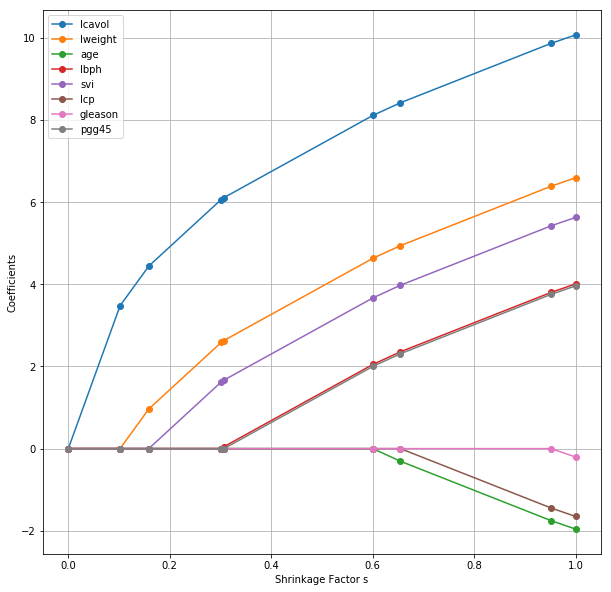

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
l1length_ols_beta = sum(abs(coeff) for coeff in beta_lars[-1])
l1length_lars_beta = [sum(abs(coeff) for coeff in beta)/l1length_ols_beta for beta in beta_lars]
ax.plot(l1length_lars_beta, beta_lars, 'o-')
ax.grid()
ax.set_xlabel('Shrinkage Factor s')
ax.set_ylabel('Coefficients')
ax.legend(dfx_train.columns)
plt.show()

For the prostate data, the LAR coefficient profile turns out to be identical to the lasso profile in FIGURE 3.10, which never crosses zero. These observations lead to a simple modification of the LAR algorithm that gives the entire lasso path, which is also piecewise-linear.

### Algorithm 3.2a. Least Angle Regression: Lasso Modification

4a. If a non-zero coefficient hits zero, drop its variable from the active set and recompute the current joint least squares direction.

### Computational efficiency

The LAR (lasso) algorithm is extremely efficient, requiring the same order of computation as that of a single least squares fit using the $p$ predictors. LAR always take $p$ steps to get to the full least squares estimates. The lasso path can have more than $p$ steps, although the two are often quite similar. Also the LAR algorithm with the lasso modification is efficient, especially when $p \gg N$. Osborne et al. (2000) also discovered a piecewise-linear path for computing the lasso, which they called a *homotopy* algorithm.

### Heuristic argument for why LAR and lasso are so similar

Although the LAR algorithm is stated in terms of correlations, if the input features are standardized, it is equivalent and easier to work with inner-products.

Let $\mathcal{A}$ be the active set at some stage, tied in their absolute inner-product with the current residuals $\mathbf{y}-\mathbf{X}\beta$, expressed as

\begin{equation}
\mathbf{x}_j^T\left( \mathbf{y}-\mathbf{X}\beta \right) = \gamma\cdot s_j, \forall j\in\mathcal{A},
\end{equation}

where $s_j\in\lbrace -1, 1\rbrace$ indicates the sign of the inner-product, and $\gamma$ is the common value. Also note that

\begin{equation}
\lvert \mathbf{x}_k^T \left( \mathbf{y}-\mathbf{X}\beta \right) \rvert \le \gamma, \forall k \notin \mathcal{A}
\end{equation}

Now consider the lasso criterion

\begin{equation}
\hat\beta^{\text{lasso}} = \arg\min_\beta \left\lbrace \frac{1}{2}\sum_{i=1}^N \left( y_i-\beta_0-\sum_{j=1}^p x_{ij}\beta_j \right)^2 + \lambda\sum_{j=1}^p |\beta_j| \right\rbrace,
\end{equation}

which we write in the vector form

\begin{equation}
R(\beta) = \frac{1}{2}\|\mathbf{y}-\mathbf{X}\beta\|^2_2 + \lambda\|\beta\|_1.
\end{equation}

Let $\mathcal{B}$ be the active set in the solution for a given value of $\lambda$. For these variables $R(\beta)$ is differentiable, and the stationary conditions give

\begin{align*}
\frac{\partial R}{\partial\beta} &= -\mathbf{X}^T(\mathbf{y}-\mathbf{X}\beta) + \lambda \frac{\partial \|\beta\|_1}{\partial\beta} = 0  \\
\mathbf{x}^T_j\left( \mathbf{y}-\mathbf{X}\beta \right) &= \lambda\cdot\text{sign}(\beta_j), \forall j\in\mathcal{B}
\end{align*}

This is identical to the above inner-product expression only if the sign of $\beta_j$ matches the sign of the inner-product. This is why the LAR and lasso start to differ when an active coefficient passes through zero; the above condition is violated for that variable, and it is kicked out of the active set $\mathcal{B}$. Exercise 3.23 shows that these equations imply a piecewise linear coefficient profile as $\lambda$ decreases.

The stationary conditions for the non-active variables require that

\begin{equation}
\lvert \mathbf{x}_k^T(\mathbf{y}-\mathbf{X}\beta) \rvert \le \lambda, \forall k\notin\mathcal{B},
\end{equation}

which again agrees with the LAR algorithm.

### Degrees-of-freedom formula for LAR and lasso

Suppose that we fit a linear model via the LAR procedure, stopping at some number of steps $k<p$, or equivalently using a lasso bound $t$ that produces a constrained version of the full least squares fit. How many parameters, or "degrees of freedom" have we used?

In classical statistics, the number of linearly independent parameters is what is meant by "degrees of freedom". So a least squares model with $k$ features has degress of freedom to be $k$. Alternatively, suppose that we carry out a best subset selection to determine the "optimal" set of $k$ predictors. Then the resulting model has $k$ parameters, but in some sense we have used up more than $k$ degrees of freedom.

We need a more general defintion for the effective degrees of freedom of an adaptively fitted model. Define the degrees of freedom of the fitted vector $\hat{\mathbf{y}}$ as

\begin{equation}
\text{df}(\hat{\mathbf{y}}) = \frac{1}{\sigma^2}\sum_{i=1}^N \text{Cov}(\hat{y}_i, y_i),
\end{equation}

where $\text{Cov}(\hat{y}_i, y_i)$ refers to the sampling covariance between $\hat{y}_i$ and $y_i$. This makes intuitive sense: The harder that we fit to the data, the larger this covariance and hence $\text{df}(\hat{\mathbf{y}})$. This is a useful notion of degrees of freedom, one that can be applied to any model prediction $\hat{\mathbf{y}}$, including models adaptively fitted to the training data. This definition is motivated and discussed further in $\S$ 7.4-7.6.

Now
* for a linear regression with $k$ fixed predictors, it is easy to show that $\text{df}(\hat{\mathbf{y}}) = k$.
* Likewise for ridge regression, $\text{df}(\hat{\mathbf{y}}) = \text{trace}(\mathbf{S}_\lambda)$.

In both these cases, $\text{df}$ is simple to evaluate because the fit

\begin{equation}
\hat{\mathbf{y}} = \mathbf{H}_\lambda \mathbf{y}
\end{equation}

is linear in $\mathbf{y}$. If we think about the above definition of degrees of freedom in the context of a best subset selection of size $k$, it seems clear that $\text{df}(\hat{\mathbf{y}}) > k$, and this can be verified by estimating $\text{Cov}(\hat{y}_i,y_i)/\sigma^2$ directly by simulation. However there is no closed form method for estimating $\text{df}$ for best subset selection.

For LAR and lasso, estimation of $\text{df}$ is more tractable since these techniques are adaptive in a smoother way than best subset selection.
* After the $k$th step of the LAR procedure, $\text{df} = k$.
* For the lasso, the modified LAR procedure often takes more than $p$ steps, since predictors can drop out. Hence the definition is a little different; for the lasso, at any stage $\text{df}$ approximately equals the number of predictors in the model.  
While this approximation works reasonably well anywhere in the lasso path, for each $k$ it works best at the *last* model in the sequence that contains $k$ predictors.

A detailed study of the effective degrees of freedom for the lasso may be found in Zou et al. (2007).